# Vessels segmentation dataset training example

This notebook shows an example of using a **Vessels segmentation dataset** to train a UNet model using PyTorch Lightning framework.

*Note*, that this noteboon based on pytorch-lightning version 1.8.0.

## Import libraries

In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
import cv2
import matplotlib.pyplot as plt
import shutil

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from monai.visualize import plot_2d_or_3d_image
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.optimizers import Novograd
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    RandFlipd,
    ScaleIntensityRanged,
    ScaleIntensityRanged,
    ToTensord,
    EnsureChannelFirstd,
    CastToTyped,
    Lambdad,
    EnsureTyped,
    RandCropByLabelClassesd,
    RandRotated
)
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.data import (
    CacheDataset,
    decollate_batch,
    ThreadDataLoader,
    PILReader,
)
from monai.data.utils import partition_dataset

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

2023-06-27 14:26:15.929901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 14:26:16.425275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/asya/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.21.0
Pillow version: 9.2.0
Tensorboard version: 2.12.3
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.2
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-depende

In [2]:
print(f'Cuda is available: {torch.cuda.is_available()}, device: {device}')
root_dir =  "./"
# print(f'root_dir: {os.path.abspath(root_dir)}')

Cuda is available: True, device: cuda


## Forming the dataset images paths

In [3]:
dataset_dir = './data'

full_dataset = []

images_list = glob(os.path.join(dataset_dir, "originals", "*.png"))
masks_list  = glob(os.path.join(dataset_dir, "masks", "*.png"))

#Sort images for reproducibility 
images_list.sort()
masks_list.sort()

print(f"Total count of images: {len(images_list)}")

#Visualize the progress
for i in tqdm(range(len(images_list))):
    case_paths = {}
    case_paths["image"] = images_list[i]
    case_paths["label"] = masks_list[i]
    if os.path.isfile(case_paths["label"]):
        full_dataset.append(case_paths)

print(f"Total count of images in the dataset: {len(full_dataset)}")

if len(images_list) != len(full_dataset):
    print("WARNING: Some images do not have labels")

train_dataset, test_dataset = partition_dataset(full_dataset, ratios=[0.8, 0.2], shuffle=True)
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

Total count of images: 98


100%|██████████| 98/98 [00:00<00:00, 162853.32it/s]

Total count of images in the dataset: 98
train_dataset: 78, test_dataset: 20


### The example image of a dataset with its label and details

Image shape: (2560, 1920, 3)
Image min value: 0
Image max value: 255
{'format': 'PNG', 'mode': 'RGB', 'width': 2560, 'height': 1920, spatial_shape: array([2560, 1920]), original_channel_dim: -1}
Label shape: (2560, 1920)
Label min value: 0
Label max value: 255
{'format': 'PNG', 'mode': 'L', 'width': 2560, 'height': 1920, spatial_shape: array([2560, 1920]), original_channel_dim: 'no_channel'}


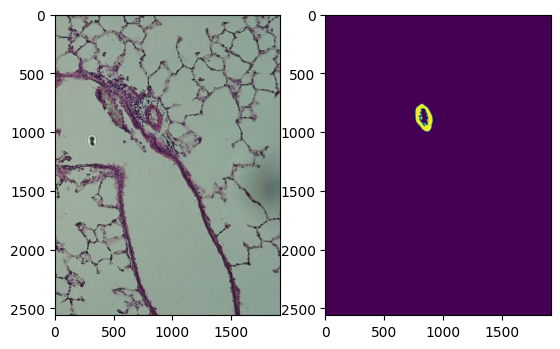

In [4]:
image_reader = PILReader()
img_obj = image_reader.read(full_dataset[45]['image'])
img_data, meta_data = image_reader.get_data(img_obj)
print(f'Image shape: {img_data.shape}')
print(f'Image min value: {img_data.min()}')
print(f'Image max value: {img_data.max()}')
print(meta_data)

img_obj = image_reader.read(full_dataset[45]['label'])
label_data, meta_data = image_reader.get_data(img_obj)
print(f'Label shape: {label_data.shape}')
print(f'Label min value: {label_data.min()}')
print(f'Label max value: {label_data.max()}')
print(meta_data)

fig = plt.figure()
plt.subplot(121)
plt.imshow(img_data)
plt.subplot(122)
plt.imshow(label_data)
plt.show()

## Defining the segmentation UNet model

In [5]:
in_channels = 3
spatial_size = (1024, 1024) # Size of network input
num_images_per_batch = 2
num_patches_per_image = 2 # Nubmer of images if sliding window aprroach is used (training step)
output_classes = 2
model_name = 'UNet'

max_epochs = 1000 # Epochs number
check_val = 5 # Validation interval


class NetModule(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=2,
            channels=(16, 32, 64, 128, 256, 512, 1024),
            strides=(2, 2, 2, 2, 2, 2),
            num_res_units=2,
        ).to(device)
        
        self.loss_function = DiceCELoss(to_onehot_y=True, softmax=True, sigmoid=False) #DiceCELoss
        self.post_pred = AsDiscrete(argmax=True, to_onehot=2)
        self.post_label = AsDiscrete(to_onehot=2)
        self.dice_metric = DiceMetric(
            include_background=False, reduction="mean", get_not_nans=False
        )
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.max_epochs = max_epochs 
        self.check_val = check_val
        self.warmup_epochs = 20
        self.metric_values = []
        self.epoch_loss_values = []

    def forward(self, x):
        return self._model(x)

    def configure_optimizers(self):
        learning_rate = 1e-2 #was 1e-2
        self.optimizer = Novograd(self._model.parameters(), learning_rate)
        self.scaler = torch.cuda.amp.GradScaler()
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.5, patience=5),
                'reduce_on_plateau': True,
                # The unit of the scheduler's step size, could also be 'step'.
                # 'epoch' updates the scheduler on epoch end whereas 'step'
                # updates it after a optimizer update.
                "interval": "epoch",
                # How many epochs/steps should pass between calls to
                # `scheduler.step()`. 1 corresponds to updating the learning
                # rate after every epoch/step.
                "frequency": self.check_val,
                # Metric to to monitor for schedulers like `ReduceLROnPlateau`
                "monitor": "val_loss",
                # If set to `True`, will enforce that the value specified 'monitor'
                # is available when the scheduler is updated, thus stopping
                # training if not found. If set to `False`, it will only produce a warning
                "strict": True,
            },
        }

    def training_step(self, batch, batch_idx):
        images, labels = (batch["image"].cuda(), batch["label"].cuda())
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        self.log("train_loss", loss.item())
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = spatial_size
        sw_batch_size = 2
        outputs = sliding_window_inference(
            images, 
            roi_size, 
            sw_batch_size, 
            self.forward,
            overlap=0.5
        )
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        if batch_idx == 0:
            sr = SummaryWriter(log_dir=self.logger.log_dir)
            plot_2d_or_3d_image(images, self.current_epoch + 1, sr, max_channels=3, index=0, tag="image")
            plot_2d_or_3d_image(labels, self.current_epoch + 1, sr, index=0, tag="label")
            plot_2d_or_3d_image(outputs, self.current_epoch + 1, sr, index=0, tag="output")
        return {"val_loss": loss, "val_number": len(outputs)}

    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
            #torch.save(self._model, "best_metric_model.pt")
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.metric_values.append(mean_val_dice)
        self.log("val_loss", mean_val_loss)
        self.log("val_dice", mean_val_dice)
        return {"log": tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = spatial_size
        sw_batch_size = 2
        outputs = sliding_window_inference(
            images, 
            roi_size, 
            sw_batch_size, 
            self.forward,
            overlap=0.5
        )
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        sr = SummaryWriter(log_dir=self.logger.log_dir)
        plot_2d_or_3d_image(images, batch_idx, sr, max_channels=3, index=0, tag="test_image")
        plot_2d_or_3d_image(labels, batch_idx, sr, index=0, tag="test_label")
        plot_2d_or_3d_image(outputs, batch_idx, sr, index=0, tag="test_output")
        return {"test_loss": loss, "test_number": len(outputs)}
    
    def test_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["test_loss"].sum().item()
            num_items += output["test_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "test_dice": mean_val_dice,
            "test_loss": mean_val_loss,
        }

        print(
            f"Test mean dice: {mean_val_dice:.4f}"
        )
        self.metric_values.append(mean_val_dice)
        self.log("test_loss", mean_val_loss)
        self.log("test_dice", mean_val_dice)
        return {"log": tensorboard_logs}

## Define training and validation transforms

In [6]:
#Training augmentations
train_transforms = Compose(
[
    LoadImaged(keys=["image", "label"]),
    CastToTyped(keys=["label"], dtype=(np.uint8)),
    EnsureChannelFirstd(keys=["image", "label"]),
    Lambdad(keys=["label"],
            func=lambda image: np.where(image < 127, 0, 1),
            overwrite=True,
            ),
    CastToTyped(keys=["image"], dtype=(torch.float32)),
    ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    CastToTyped(keys=["image", "label"], dtype=(np.float16, np.uint8)),
    EnsureTyped(keys=["image", "label"]),
    CastToTyped(keys=["image"], dtype=(torch.float32)),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        num_classes=output_classes,
        ratios=[1,] * output_classes,
        spatial_size=spatial_size,
        num_samples=num_patches_per_image
    ),
    RandRotated(keys=["image", "label"], range_x=0.3, range_y=0.3, range_z=0.3, mode=["bilinear", "nearest"], prob=0.4),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.7),
    RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.7),
    CastToTyped(keys=["image", "label"], dtype=(torch.float32, torch.uint8)),
    ToTensord(keys=["image", "label"]),
]
)

#Validating augmentations
val_transforms = Compose(
[
    LoadImaged(keys=["image", "label"]),#, reader=PILReader()),
    CastToTyped(keys=["label"], dtype=(np.uint8)),
    EnsureChannelFirstd(keys=["image", "label"]),
    #transforms.Grayscale(num_output_channels=1),
    Lambdad(keys=["label"],
            func=lambda image: np.where(image == 0, 0, 1),
            overwrite=True,
            ),
    CastToTyped(keys=["image"], dtype=(torch.float32)),
    ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
]
)

In [7]:
#Training data loader
train_ds = CacheDataset(data=train_dataset,
                        transform=train_transforms,
                        cache_rate=1.0,
                        cache_num=100,
                        num_workers=14,
                        )
train_loader = ThreadDataLoader(train_ds, 
                                num_workers=2, 
                                batch_size=num_images_per_batch, 
                                shuffle=False,
                                )


#Testing data loader
test_ds = CacheDataset(data=test_dataset,
                        transform=val_transforms,
                        cache_rate=1.0,
                        cache_num=100,
                        num_workers=14,
                        )
test_loader = ThreadDataLoader(test_ds, 
                                num_workers=2, 
                                batch_size=1, 
                                shuffle=False,
                                )

Loading dataset: 100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


In [8]:
tb_logger = TensorBoardLogger(save_dir=os.path.join(root_dir, 'history'), name=f'{model_name}_auto_so', version=f'0')
checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir + "/{epoch:02d}-{val_metric:.4f}", 
                                      monitor='val_dice', mode='max', verbose=1)
early_stop_callback = EarlyStopping(monitor="val_dice", min_delta=0.00, patience=10, verbose=False, mode="max")
lr_logger = LearningRateMonitor()
model = NetModule()

# Delete old logs:
# shutil.rmtree('./history', ignore_errors=True)

## The training process
You can skip this cell and jump to the next one, where a trained version of this model will be loaded

In [ ]:
trainer = pytorch_lightning.Trainer(gpus=-1,# Use all GPUs
                                    logger=tb_logger, 
                                    max_epochs=600,
                                    check_val_every_n_epoch=model.check_val,
                                    enable_checkpointing=[early_stop_callback, checkpoint_callback, lr_logger],
                                    strategy=None, #"dp",
                                    log_every_n_steps=10,
                                    #accumulate_grad_batches=5, # Use gradient accumulation
                                   )
trainer.fit(model,
            train_dataloaders=train_loader, 
            val_dataloaders=test_loader)

### Loading a previously trained version

In [9]:
checkpoint = glob(f'./history/{model_name}_auto_so/0/checkpoints/*.ckpt')
print(f'Loaded checkpoints {checkpoint}')

Loaded checkpoints ['./history/UNet_auto_so/0/checkpoints/UNET_6_channels_1024.ckpt']


In [10]:
modelSeg = NetModule.load_from_checkpoint(f'./history/{model_name}_auto_so/0/checkpoints/UNET_6_channels_1024.ckpt')
modelSeg.eval()

NetModule(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequential(
   

## Define necessary functions for the postprocessing

In [11]:
# A function to perform a prediction
def predictOutput(image):
    with torch.no_grad():
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype("float32") / 255.0
            image = cv2.resize(image, spatial_size)
            image = np.transpose(image, (2, 0, 1))
            image = np.expand_dims(image, 0)
            image = torch.from_numpy(image).to(device)
            
            predMask = modelSeg(image).squeeze()
            
            predMask = torch.sigmoid(predMask)
            predMask = predMask.cpu().numpy()
            predMask = (predMask) * 255
            predMask = predMask.astype(np.uint8)
            
            return predMask[1,:,:]


# A function to draw all contours with filtering the small ones out
def drawContours(img):
    contours, hiers= cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    conts = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(len(contours)):
            mask = cv2.drawContours(conts, contours, i, (255,255,0))
    return mask

# A function to locate the internal area of an annular shape in an image
def fillandExclude(gray):
    im_floodfill = gray.copy()
    h, w = gray.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = gray | im_floodfill_inv
    img_internal = im_out - gray
    img_internal = cv2.morphologyEx(img_internal, cv2.MORPH_OPEN, kernel)
    return img_internal

## Perform predictions

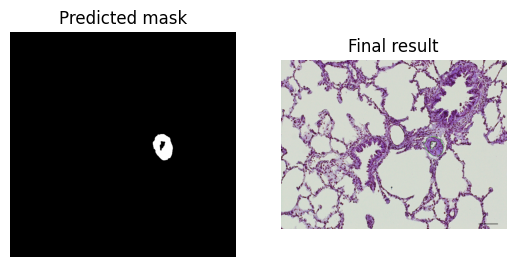

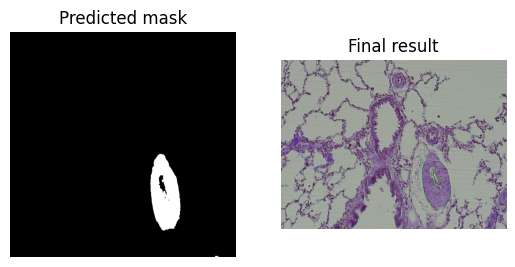

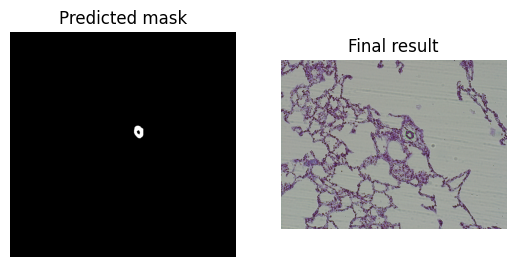

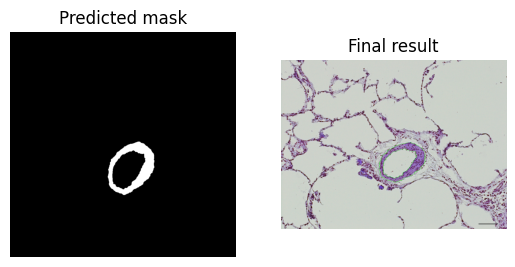

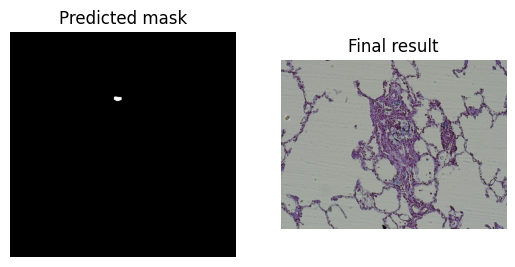

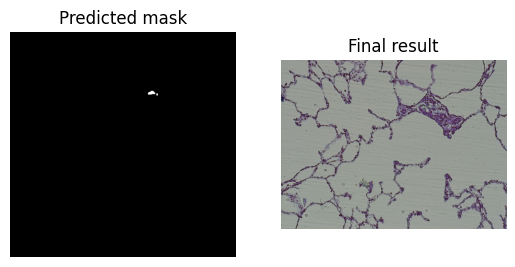

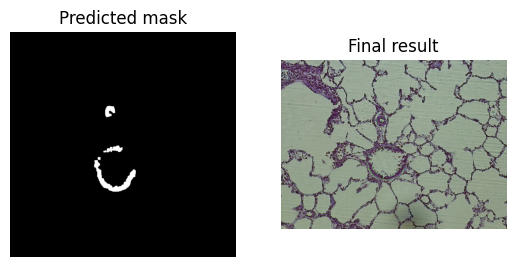

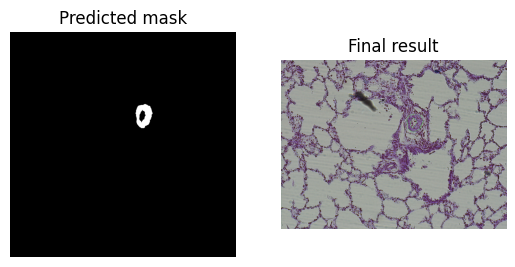

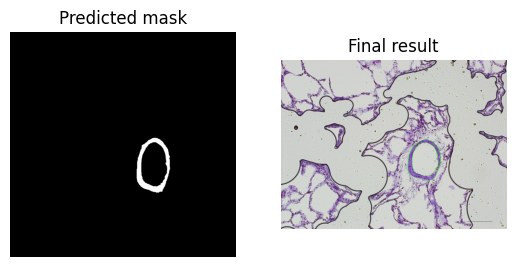

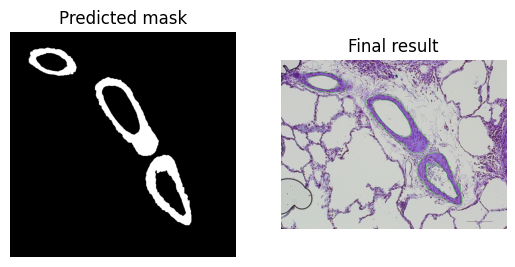

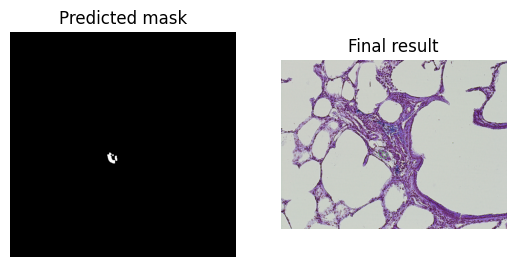

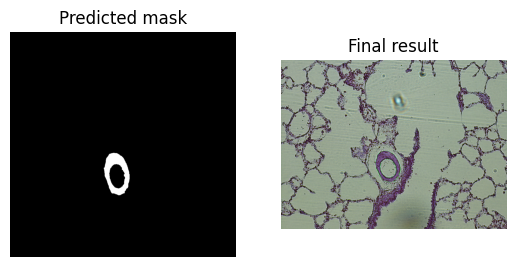

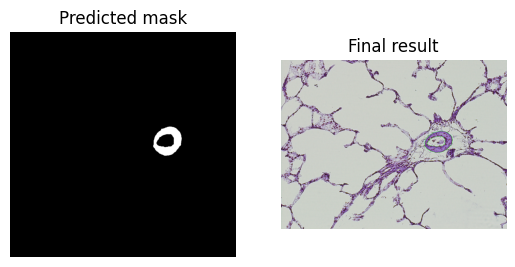

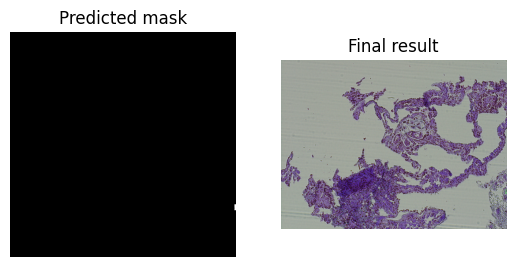

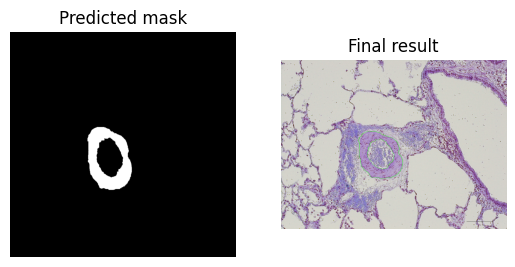

In [12]:
path = os.path.join(dataset_dir, "originals") # Path to images to be preicted
images_count = 15

for i, img_name in enumerate(os.listdir(path)[:images_count]):
    window_size = 768 # You can use different windows to get the best result
    img = cv2.imread(os.path.join(path, img_name)) #[window_size:2*window_size, window_size:2*window_size]
    mask = predictOutput(img)

    # Otsu's thresholding followed by morphological opening with 7x7 filter
    ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((7,7), np.uint8))
    
    # Finding the mask contours and draw them, and then resize it to the original image shape to merge it with the contours
    mask = drawContours(opening)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    
    # Merging contours with the original image (Yellow coloured contours)
    rgbBorders = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    final = cv2.add(rgbBorders,img)
    final_cont = np.where(final[:,:]==[255, 255, 255], [0, 255, 0], final[:,:])
    
    # Plotting out the final resul
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(opening)
    plt.title('Predicted mask')

    plt.subplot(1, 2, 2)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.imshow(final_cont)
    plt.title('Final result')
    plt.show()